# EJERCICIO 1

1. Deberá crear un modelo que pueda pronosticar la demanda de 2022-05, 06 y 07, de Cementos Argos

### IMPORTAR LIBRERIAS

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from config.config_file import PATH_DEMAND_DATA_FILE

### Cargar datos desde el csv


In [160]:
data = pd.read_csv(PATH_DEMAND_DATA_FILE, sep=',')
data

,year_month,Demand
0,2017-01,1211.009490
1,2017-02,1660.584649
2,2017-03,3182.587014
3,2017-04,3506.515270
4,2017-05,4554.082280
...,...,...
59,2021-12,3006.311107
60,2022-01,217.314949
61,2022-02,332.062614
62,2022-03,609.119726


#### Verificación de tipo de datos y estadística básica

In [161]:
data.dtypes

year_month     object
Demand        float64
dtype: object

In [162]:
print('\nEstadística de datos en el DataFrame:')  
data.describe()


Estadística de datos en el DataFrame:


,Demand
count,64.000000
mean,2600.044986
std,1943.995938
min,217.314949
25%,1034.370651
50%,1947.817229
75%,4216.465081
max,7686.307292


#### Verificación de datos nulos/faltantes

In [163]:
print('Datos nulos en el DataFrame:')
data.isnull().sum()

Datos nulos en el DataFrame:


year_month    0
Demand        0
dtype: int64

Mover el índice 'year_month' a una columna y renombrarla a 'Date'

In [164]:
data.rename(columns={'year_month': 'Date'}, inplace=True)
data

,Date,Demand
0,2017-01,1211.009490
1,2017-02,1660.584649
2,2017-03,3182.587014
3,2017-04,3506.515270
4,2017-05,4554.082280
...,...,...
59,2021-12,3006.311107
60,2022-01,217.314949
61,2022-02,332.062614
62,2022-03,609.119726


#### Convertir la columna Date a tipo datetime y establecer la columna Date como índice

In [165]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data

,Demand
Date,
2017-01-01,1211.009490
2017-02-01,1660.584649
2017-03-01,3182.587014
2017-04-01,3506.515270
2017-05-01,4554.082280
...,...
2021-12-01,3006.311107
2022-01-01,217.314949
2022-02-01,332.062614


### VISUALIZACIÓN DE LOS VALORES INICIALES

Se realiza una visualización preliminar para determinar el comportamiento de los datos en el tiempo.

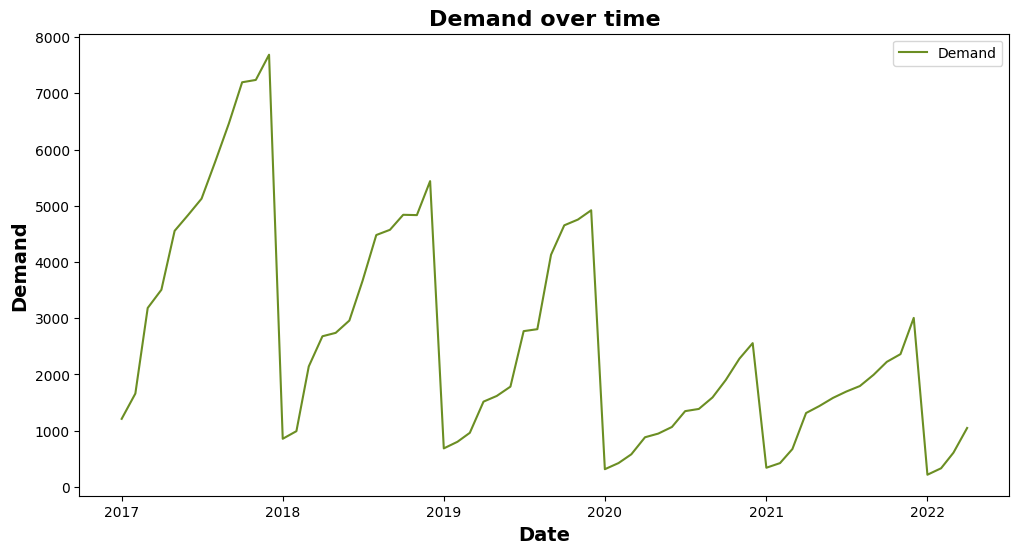

In [166]:
plt.figure(figsize=(12, 6), dpi=100)
sns.lineplot(data=data, x='Date', y='Demand', label='Demand', color='olivedrab')

plt.title('Demand over time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Demand', fontsize=14, fontweight='bold')
plt.legend()

plt.show()

Los datos presentan estacionalidad, lo que indica patrones repetitivos en diferentes años.
Se observan picos correspondientes a periodos de alta demanda seguido de caídas. Sin embargo, la amplitud de esas fluctuaciones estacionales disminuye a medida que la demanda general disminuye también despues del 2018. La variación en la estacionalidad parece ser proporcional al nivel de tendencia, i.e. a mayor demanda, mayor es la fluctuación estacional. 

Esto me lleva a concluir que la descomposición estacional debe realizarse a través del modelo multiplicativo.

Series de tiempo multiplicativa:

Valor = Tendencia * Estacionalidad * Residuo 

#### Copia Dataset

In [167]:
df = data.copy()

 ### Descomposición Estacional
 Descompone una serie temporal en sus componentes:

Tendencia (movimiento a largo plazo).

Estacionalidad (patrones que se repiten en intervalos fijos).

Residual (ruido o variabilidad no explicada).

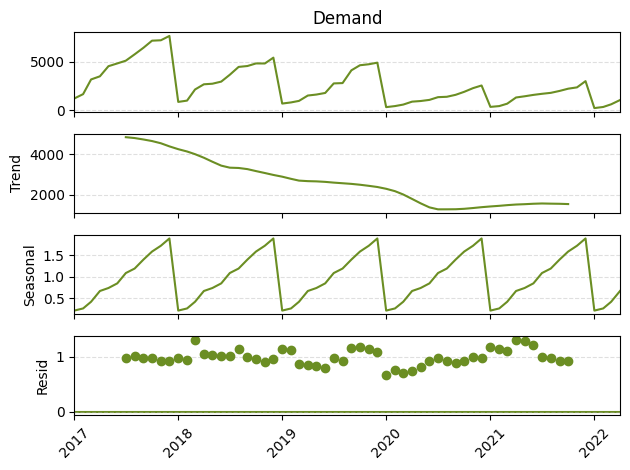

In [168]:
descompose_data = seasonal_decompose(df['Demand'], model='multiplicative', period=12)
fig = descompose_data.plot()
axes = fig.get_axes()

wanted_color = 'olivedrab'

for ax in axes:
    for line in ax.get_lines():
        line.set_color(wanted_color)
        line.set_linewidth(1.5)


    for coll in ax.collections:
        coll.set_color(wanted_color)


for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.4)


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


El gráfico nos muestra fluctuaciones cíclicas confirmando la estacionalidad de los datos, la serie presenta una tendencia descendente lo que nos puede estar indicando un cambio en la demanda después del 2018. Otra cosa para resaltar es la tendencia que cae constantemente hasta 2020 y luego entre el 2021 y 2022 se observa un ligero aumento.

El componente del residuo nos muestra como los valores se encuentran en su mayoría centrados alrededor del 1, lo cual es esperado para el modelo multiplicativo. Además, el componente estacional se normaliza alrededor de 1, no se escala según el nivel de la serie temporal.

Por lo tanto, aunque la amplitud estacional observada parecía proporcional en el gráfico original, el componente estacional aquí pretende mostrar un efecto multiplicativo relativo, no valores absolutos.

### Dividir los datos en set de entrenamiento y de prueba

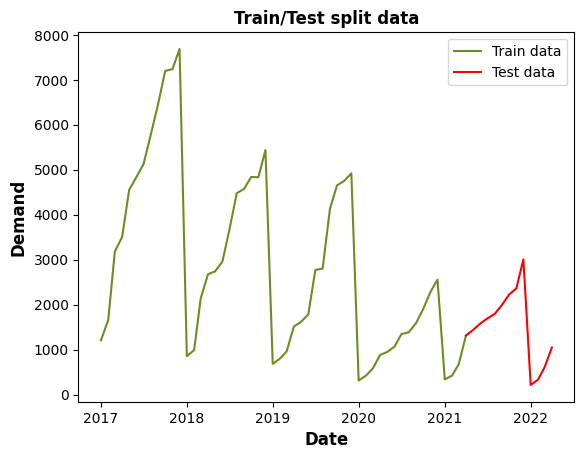

In [ ]:
train_size = int(len(df) * 0.8)

train_data, test_data = df.iloc[:train_size + 1], df.iloc[train_size:]

plt.plot(train_data, color = 'olivedrab', label = 'Train data')
plt.plot(test_data, color = 'red', label ='Test data')
plt.ylabel('Demand', fontsize = 12, fontweight = 'bold')
plt.xlabel('Date', fontsize = 12, fontweight = 'bold')
plt.xticks(rotation = 0)
plt.legend(loc ='upper right')
plt.title('Train/Test split data', fontsize = 12, fontweight = 'bold')
plt.show()

# MODELOS
Dada la estacionalidad de los datos se proponen usar cuatro modelos:

### Holt–Winters (Triple Exponential Smoothing): 
Método de suavizado exponencial que modela simultáneamente nivel, tendencia y estacionalidad; ideal para series con ciclo fijo y tendencia suave.
### ARIMA (AutoRegressive Integrated Moving Average):
Combina autorregresión, diferenciación para estacionariedad y promedio móvil; apropiado cuando no hay estacionalidad fuerte o tras eliminarla manualmente.
### SARIMAX (Seasonal ARIMA con Exógenas)  
Extiende ARIMA incluyendo un componente estacional fijo (p,d,q)×(P,D,Q,s) y variables exógenas; recomendado para datos con estacionalidad clara y regresores adicionales.
### Prophet (Facebook/Meta)  
Modelo de tendencia “piecewise” con detección automática de puntos de cambio y múltiples estacionalidades (anual, semanal, festivos); útil para series con ciclos complejos y eventos especiales.



## Holt-Winters Model

In [ ]:
hw_model = ExponentialSmoothing(train_data['Demand'], trend = 'mul', seasonal = 'mul', seasonal_periods = 12)
hw_fit = hw_model.fit()
hw_pred = hw_fit.forecast(len(test_data))

hw_mse = mean_squared_error(test_data['Demand'], hw_pred)
hw_mae = mean_absolute_error(test_data['Demand'], hw_pred)
hw_rmse = np.sqrt(hw_mse)
hw_mape = mean_absolute_percentage_error(test_data['Demand'], hw_pred)

print(f'Holt-Winters Metrics: \nMSE = {hw_mse} \nMAE = {hw_mae} \nRMSE = {hw_rmse} \nMAPE = {hw_mape}')

c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Holt-Winters Metrics: 
MSE = 1010523.566854875 
MAE = 744.3062586730264 
RMSE = 1005.2480126092639 
MAPE = 0.5292707247452968


c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## SARIMAX Model 


In [175]:
sarimax_model = SARIMAX(train_data['Demand'], order=(0, 0, 1), seasonal_order=(1, 0, 0, 12))
sarimax_fit = sarimax_model.fit()
sarimax_pred = sarimax_fit.predict(start = len(train_data), end = (len(train_data) + len(test_data) - 1), typ ='levels')

sarimax_mse = mean_squared_error(test_data['Demand'], sarimax_pred)
sarimax_mae = mean_absolute_error(test_data['Demand'], sarimax_pred)
sarimax_rmse = np.sqrt(sarimax_mse)
sarimax_mape = mean_absolute_percentage_error(test_data['Demand'], sarimax_pred)

print(f'SARIMAX Metrics: \nMSE = {sarimax_mse} \nMAE = {sarimax_mae} \nRMSE = {sarimax_rmse} \nMAPE = {sarimax_mape}')


c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX Metrics: 
MSE = 656139.344151372 
MAE = 475.1671732409902 
RMSE = 810.024286149108 
MAPE = 0.3986882056438018


c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


## ARIMA MODEL

In [176]:
arima_model = ARIMA(train_data['Demand'], order=(1, 1, 0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test_data))

arima_mse = mean_squared_error(test_data['Demand'], arima_pred)
arima_mae = mean_absolute_error(test_data['Demand'], arima_pred)
arima_rmse = np.sqrt(arima_mse)
arima_mape = mean_absolute_percentage_error(test_data['Demand'], arima_pred)

print(f'ARIMA Metrics: \nMSE = {arima_mse} \nMAE = {arima_mae} \nRMSE = {arima_rmse} \nMAPE = {arima_mape}')


c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA Metrics: 
MSE = 656082.441948237 
MAE = 669.9296243416816 
RMSE = 809.98916162393 
MAPE = 0.9111923283057423


## PROPHET MODEL

In [178]:
from prophet import Prophet
prophet_data = df.reset_index().rename(columns={'Date': 'ds', 'Demand': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_data)
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='M')
forecast = prophet_model.predict(future)

prophet_pred = forecast['yhat'][-len(test_data):].values

prophet_mse = mean_squared_error(test_data['Demand'], prophet_pred)
prophet_mae = mean_absolute_error(test_data['Demand'], prophet_pred)
prophet_rmse = np.sqrt(prophet_mse)
prophet_mape = mean_absolute_percentage_error(test_data['Demand'], prophet_pred)


print(f'Prophet MSE: \nMSE = {prophet_mse} \nMAE = {prophet_mae} \nRMSE = {prophet_rmse} \nMAPE = {prophet_mape}')


17:48:04 - cmdstanpy - INFO - Chain [1] start processing
17:48:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet MSE: 
MSE = 3707020.9902489143 
MAE = 1344.761740574322 
RMSE = 1925.3625607269178 
MAPE = 1.7317183922095352


c:\Estudio\prueba_tecnica_gestor\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


### COMPARACIÓN DE LOS RESULTADOS

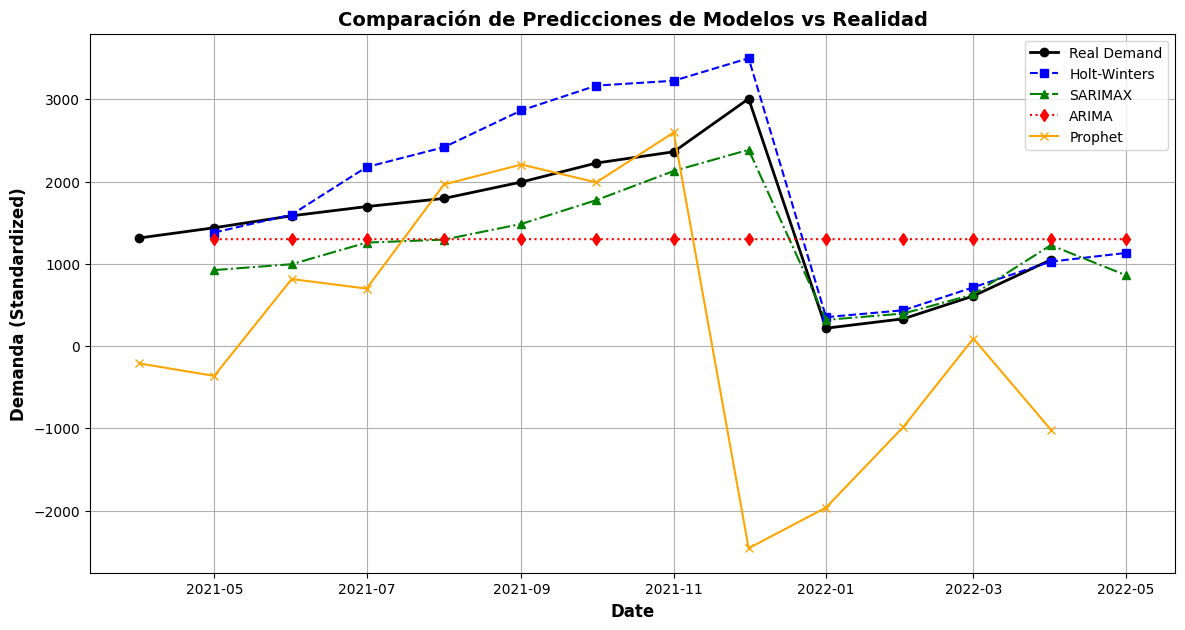

In [179]:
plt.figure(figsize=(14, 7), dpi=100)

plt.plot(test_data.index, test_data['Demand'], label='Real Demand', color='black', linewidth=2, marker='o')
plt.plot(hw_pred.index, hw_pred.values, label='Holt-Winters', color='blue', linestyle='--', marker='s')
plt.plot(sarimax_pred.index, sarimax_pred.values, label='SARIMAX', color='green', linestyle='-.', marker='^')
plt.plot(arima_pred.index, arima_pred.values, label='ARIMA', color='red', linestyle=':', marker='d')
plt.plot(test_data.index, prophet_pred, label='Prophet', color='orange', linestyle='-', marker='x')

plt.title('Comparación de Predicciones de Modelos vs Realidad', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Demanda (Standardized)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### TABLA DE RESULTADOS

In [180]:
results = pd.DataFrame({
    'Model': ['Holt-Winters', 'SARIMAX', 'ARIMA', 'Prophet'],
    'MSE': [hw_mse, sarimax_mse, arima_mse, prophet_mse],
    'MAE': [hw_mae, sarimax_mae, arima_mae, prophet_mae],
    'RMSE': [hw_rmse, sarimax_rmse, arima_rmse, prophet_rmse],
    'MAPE': [hw_mape, sarimax_mape, arima_mape, prophet_mape]
})
print('\nTabla de Resultados:')
print(results)


Tabla de Resultados:
          Model           MSE          MAE         RMSE      MAPE
0  Holt-Winters  1.010524e+06   744.306259  1005.248013  0.529271
1       SARIMAX  6.561393e+05   475.167173   810.024286  0.398688
2         ARIMA  6.560824e+05   669.929624   809.989162  0.911192
3       Prophet  3.707021e+06  1344.761741  1925.362561  1.731718


Los resultados de la tabla muestran claramente que tanto ARIMA como Prophet presentan errores de validación (MSE, MAE, RMSE, MAPE) sustancialmente mayores que los de Holt–Winters y SARIMAX. En particular:

ARIMA: Aunque modela bien las dinámicas de autocorrelación, obtiene un MSE y un RMSE notablemente superiores a los de SARIMAX. Además, su MAPE indica un error porcentual medio mayor que el modelo estacional. Además, ARIMA es un modelo diseñado para series de tiempo que no tienen un componente de estacionalidad o que dicho componente ha sido removido, por lo tanto, no tiene validez su aplicación sobre este conjunto de datos.

Prophet (Facebook): Obtiene los peores indicadores de los cuatro. Un MAPE mayor a 1 lo que revela que la detección automática de “changepoints” y la combinación de estacionalidades que propone Prophet no captura adecuadamente el patrón particular de la serie. 

Dado que nuestro objetivo es optimizar la precisión del pronóstico en los próximos tres meses, se decide descartar Prophet y ARIMA y concentrarse en los otros modelos que mostraron mejor desempeño.

### Forecasting de los próximos 3 meses

In [183]:
hw_pred_future = hw_fit.forecast(len(test_data) + 2)
hw_pred_future = hw_pred_future[-3:]

print(f'Pronóstico de los próximos 3 meses con el modelo Holt-Winters:\n{hw_pred_future}')

Pronóstico de los próximos 3 meses con el modelo Holt-Winters:
2022-05-01    1131.719220
2022-06-01    1310.302613
2022-07-01    1784.113042
Freq: MS, dtype: float64


In [184]:
sarimax_pred_future = sarimax_fit.forecast(len(test_data) + 2)
sarimax_pred_future = sarimax_pred_future[-3:]
print(f'Pronóstico de los próximos 3 meses con el modelo SARIMAX:\n{sarimax_pred_future}')


Pronóstico de los próximos 3 meses con el modelo SARIMAX:
2022-05-01     862.076838
2022-06-01     928.338370
2022-07-01    1173.515279
Freq: MS, Name: predicted_mean, dtype: float64


### TABULACIÓN DE LOS RESULTADOS

In [186]:
future_dates = pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')
future_df = pd.DataFrame({
    'Date': future_dates,
    'Holt-Winters': hw_pred_future,
    'SARIMAX': sarimax_pred_future,
})
future_df.set_index('Date', inplace=True)
print('\nPredicciones Futuras:')
future_df



Predicciones Futuras:


C:\Users\damak\AppData\Local\Temp\ipykernel_34744\1657266288.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')


,Holt-Winters,SARIMAX
Date,,
2022-05-31,1131.719220,862.076838
2022-06-30,1310.302613,928.338370
2022-07-31,1784.113042,1173.515279


In [ ]:
data_predicciones = df.copy()
data_predicciones = pd.concat([df, future_df])
print('\nDataFrame con las predicciones futuras:')
data_predicciones.tail() 

,Demand,Holt-Winters,SARIMAX
Date,,,
2022-03-01,609.119726,NaN,NaN
2022-04-01,1048.486287,NaN,NaN
2022-05-31,NaN,1131.719220,862.076838
2022-06-30,NaN,1310.302613,928.338370
2022-07-31,NaN,1784.113042,1173.515279


### RESULTADOS FINALES

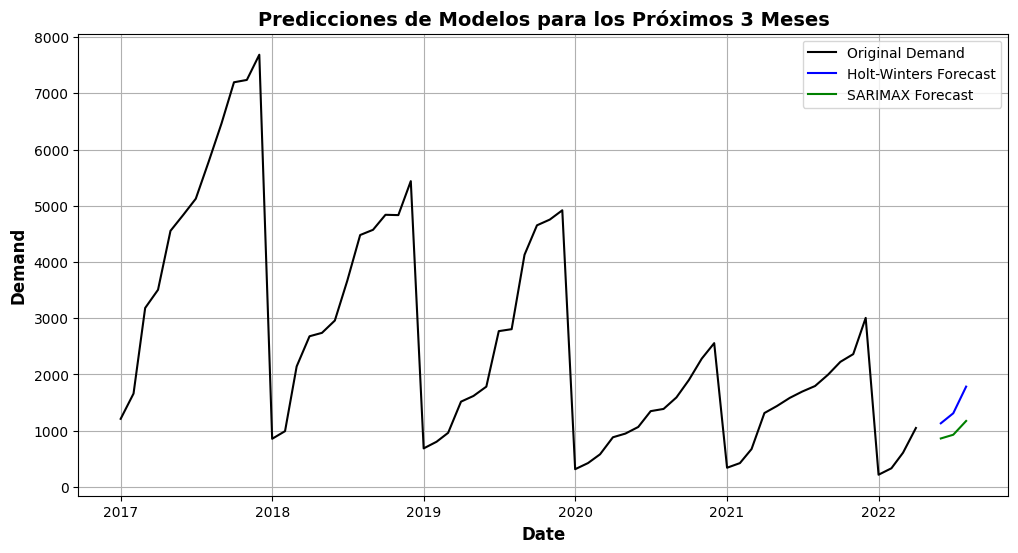

In [189]:
plt.figure(figsize=(12, 6), dpi=100)

sns.lineplot(data=df, x='Date', y='Demand', label='Original Demand', color='black')
sns.lineplot(data=future_df, x=future_df.index, y='Holt-Winters', label='Holt-Winters Forecast', color='blue')  
sns.lineplot(data=future_df, x=future_df.index, y='SARIMAX', label='SARIMAX Forecast', color='green')

plt.title('Predicciones de Modelos para los Próximos 3 Meses', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Demand', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True)

plt.show()

### CONCLUSIONES
- El los datos presentaban un componente estacional, que se ajustaban más a un modelo multiplicativo.
- Los datos se ajustaron con cuatro modelos (ARIMA, SARIMAX, Holt-Winters, Prophet), donde solo dos de los modelos, Holt-winters y SARIMAX, presentaron el mejor ajuste.
- Con los datos obtenidos y el gráfico final se puede concluir que las predicciones del modelo `Holt-Winters` para los próximos tres meses se ajustan mejor que las del modelo `SARIMAX` a la tendencia observada en los periodos anteriores. Como se puede observar en la `Tabla` el modelo `Holt-Winters` pronostica un incremento en la demanda  en los  próximos tres meses, mientras que `SARIMAX` experimenta un descenso incial para luego empezar a crecer nuevamente. Este comportamiendo no es consistente con el patrón histórico que presenta la gráfica para los meses anteriores. Por lo anterior, la predicción de `Holt-Winters` se considera la más adeacuada para este set de datos.

<br>

**Tabla: DataFrame con las predicciones futuras:**


| Fecha       | Demanda Real | Holt-Winters | SARIMAX   |
|-------------|---------------|---------------|------------|
| 2022-03-01  | 609.12        | NaN           | NaN        |
| 2022-04-01  | 1048.49       | NaN           | NaN        |
| 2022-05-31  | NaN           | `1131.72`       | 862.08     |
| 2022-06-30  | NaN           | 1310.30       | 928.34     |
| 2022-07-31  | NaN           | 1784.11       | 1173.52    |

